In [6]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


F	January
G	February
H	March
J	April
K	May
M	June
N	July
Q	August
U	September
V	October
X	November
Z	December

In [7]:
list_of_markets=get_market_list()

# Testing loading data from Arctic database

In [8]:
df=pd.DataFrame()
for m in list_of_markets:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

RU
S


# Create lot sizing
12 month momentum per market returns with lot sizing

$$ \frac{signal}{\sigma * LotMultiplier} $$

In [34]:

data=df
signal_lookback=250
vol_lookback=20

mul=get_contract_multipliers()
vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
signal=pd.rolling_mean(data,signal_lookback)
signal = signal /abs(signal)
position=(signal / (vol*mul) )

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,center=False).mean()


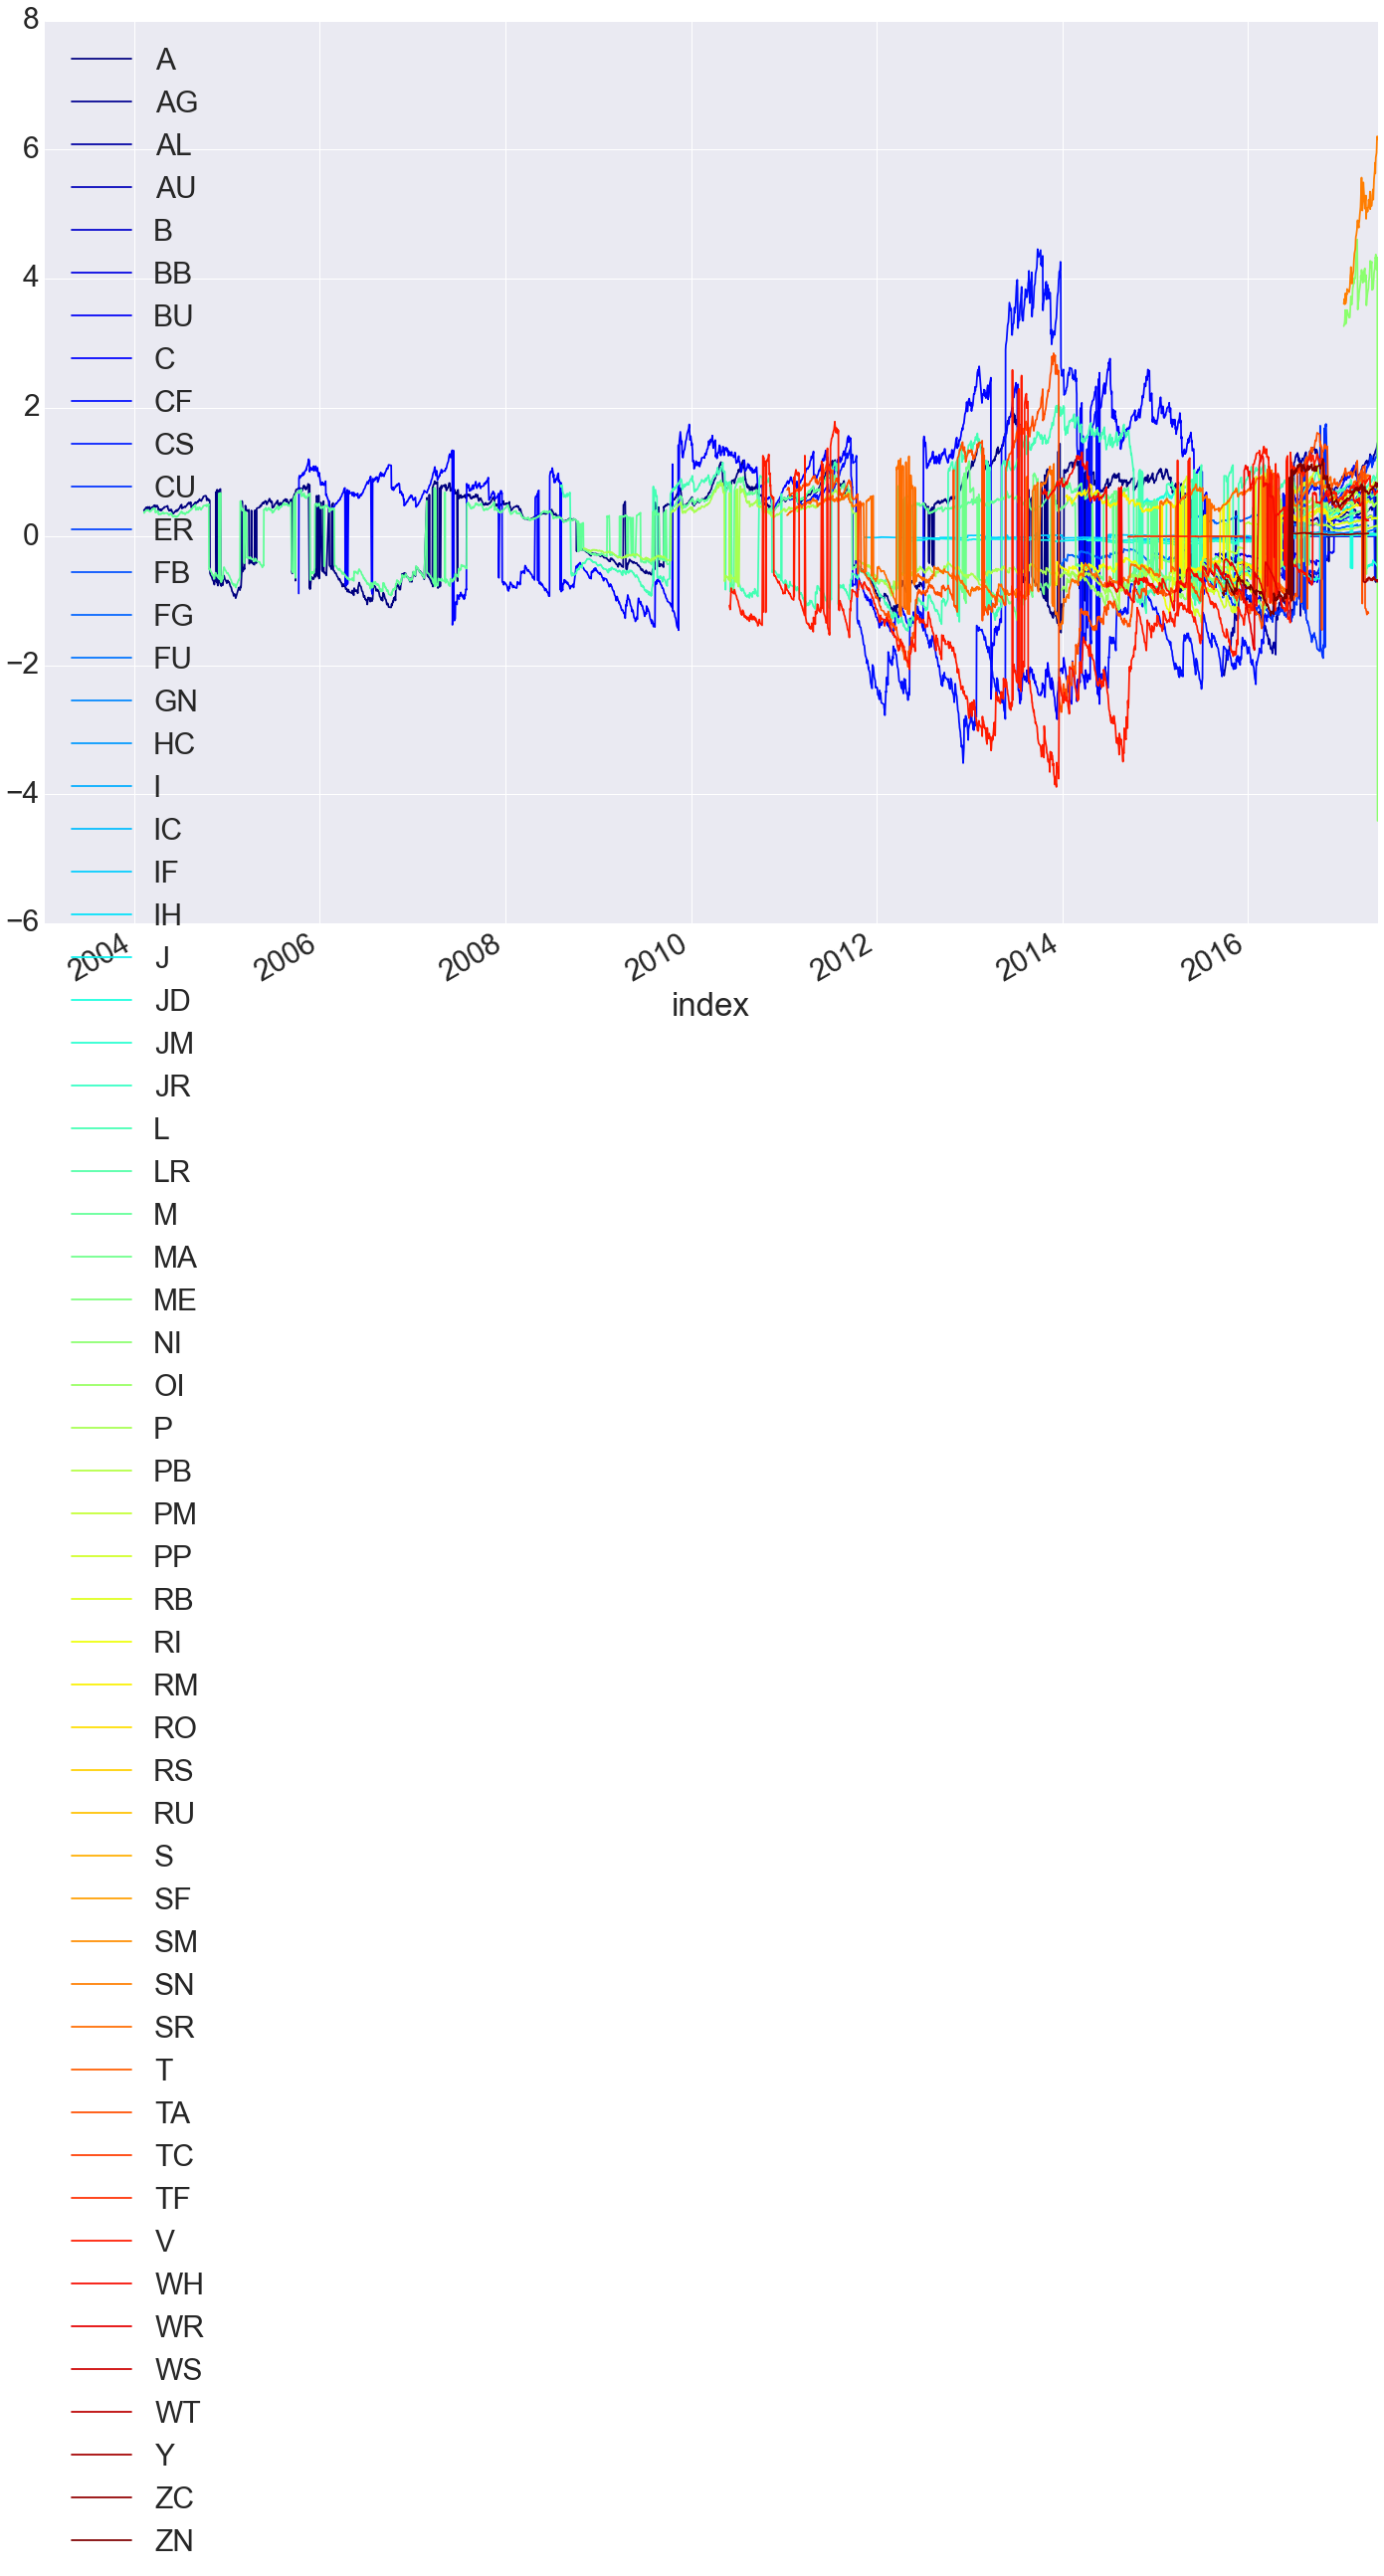

In [39]:
position.plot(colormap='jet')

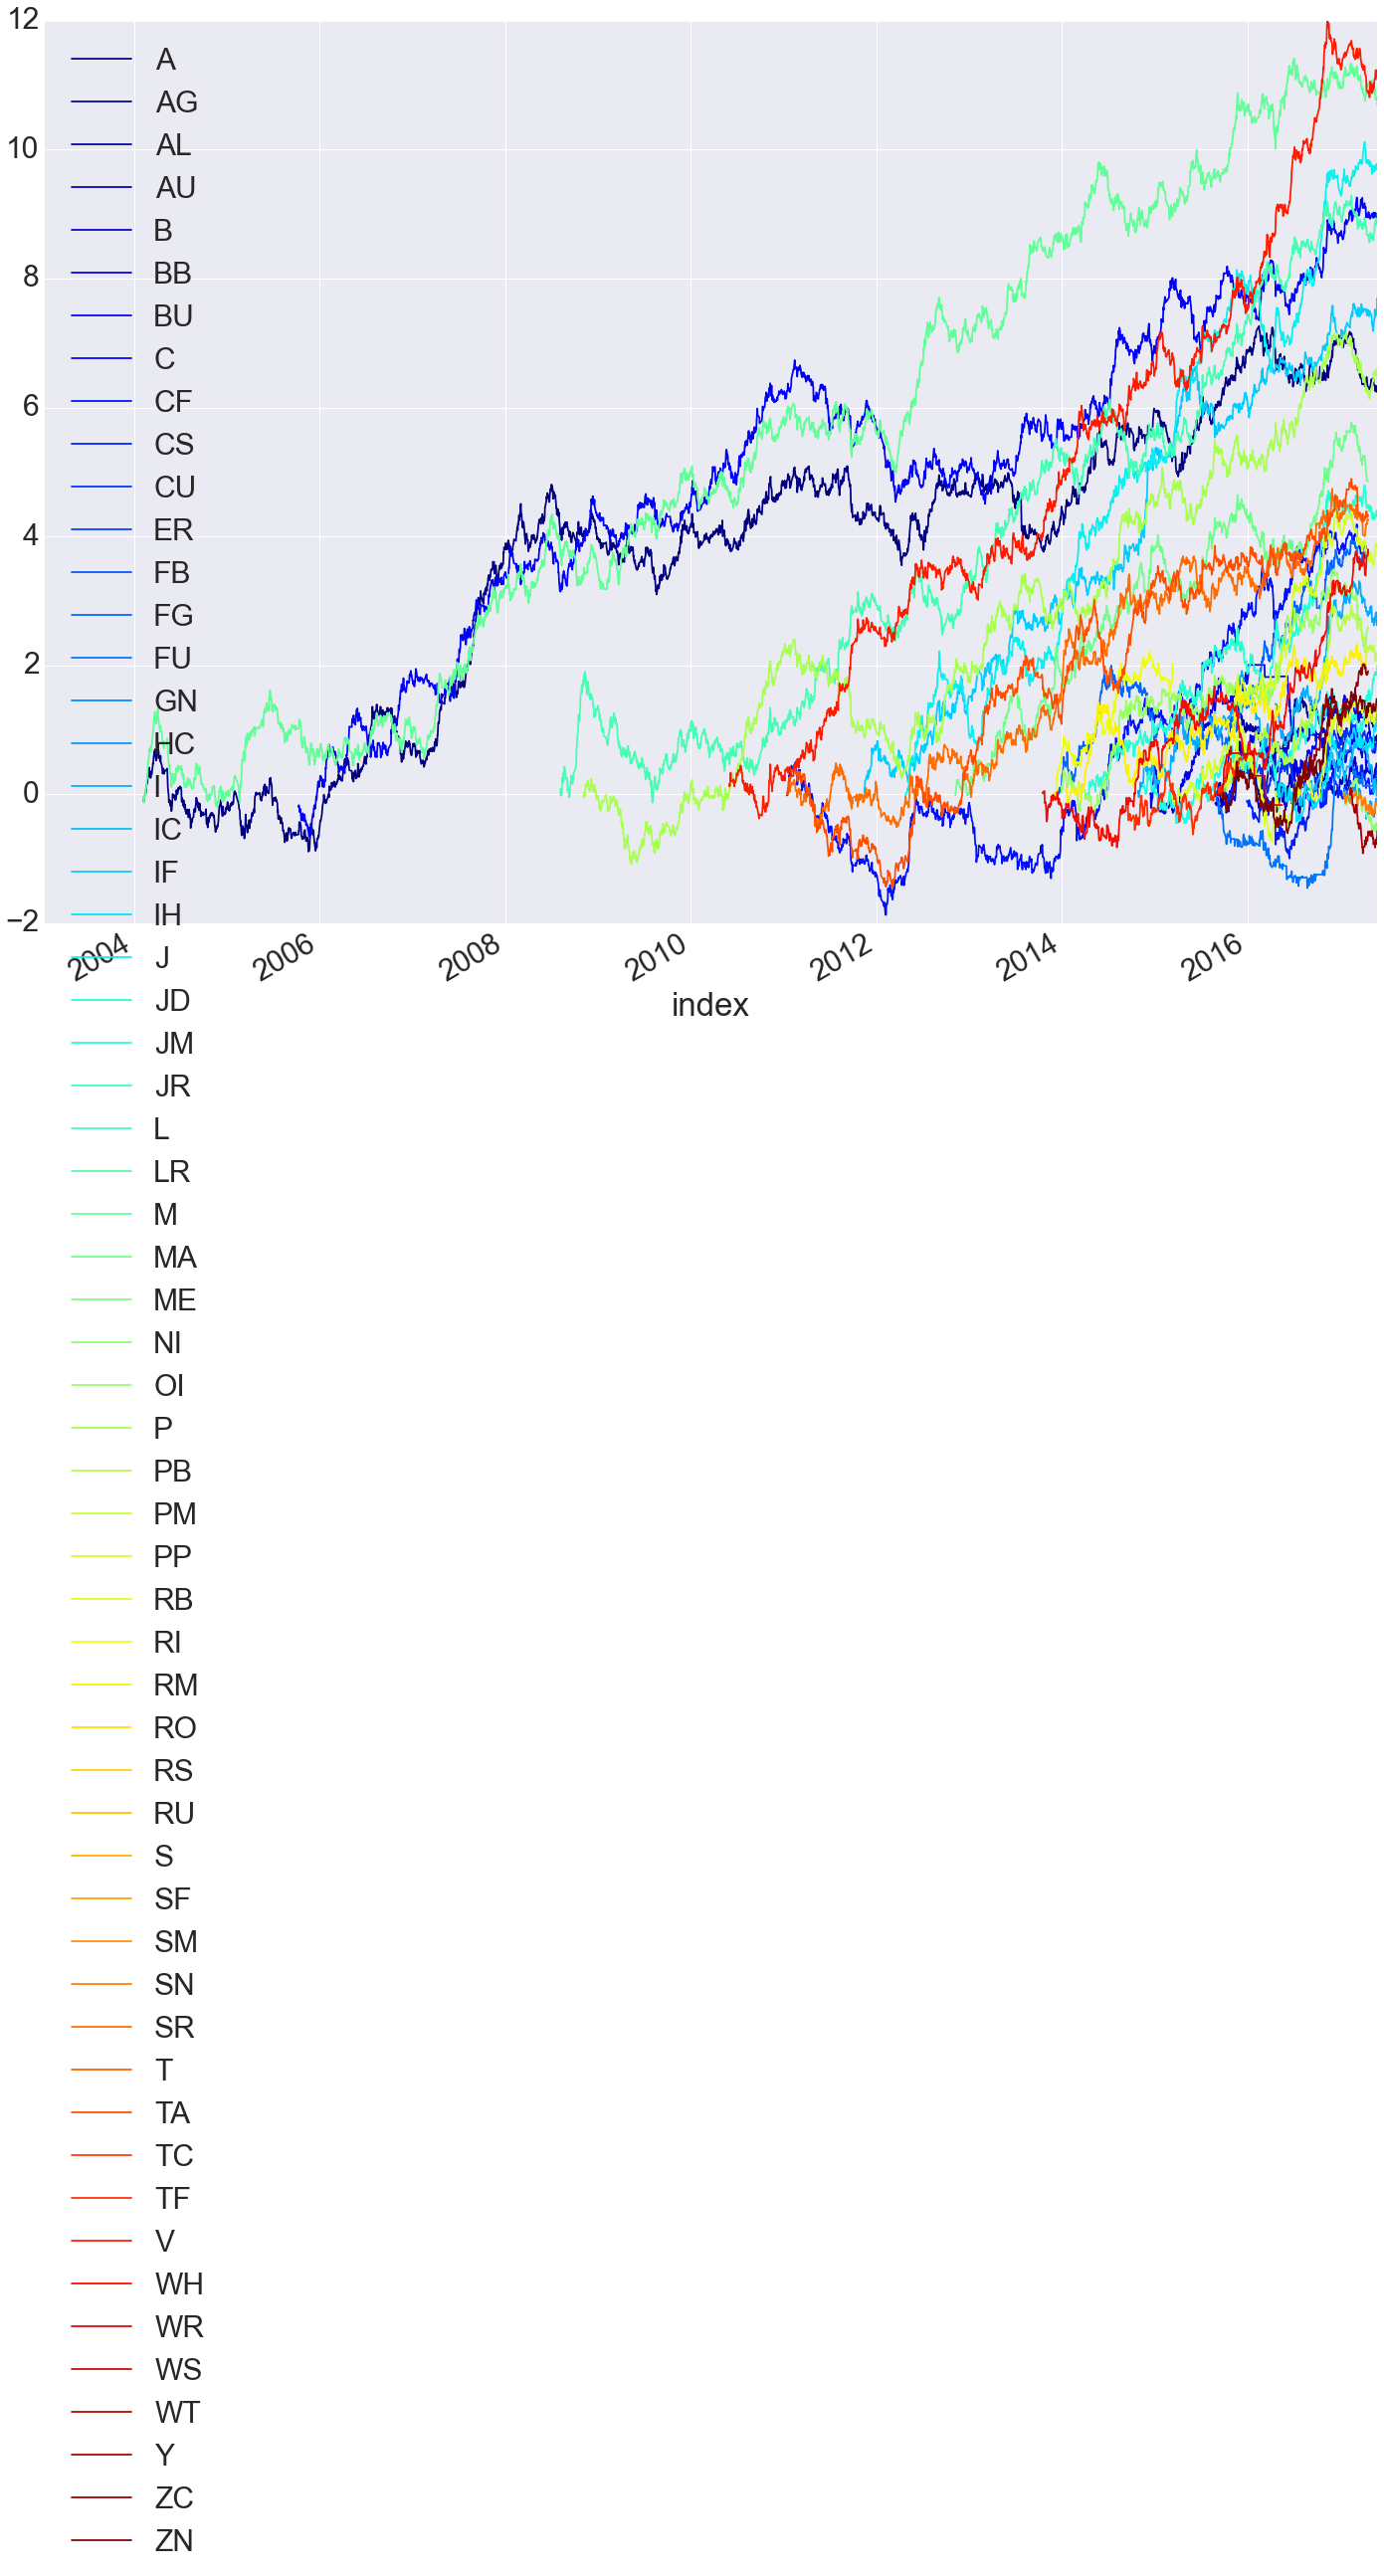

In [42]:
pos=position
pnl=calc_contract_pnl(pos,df)
sr=calc_Sharpe(pnl)
pnl.cumsum().plot(colormap='jet')

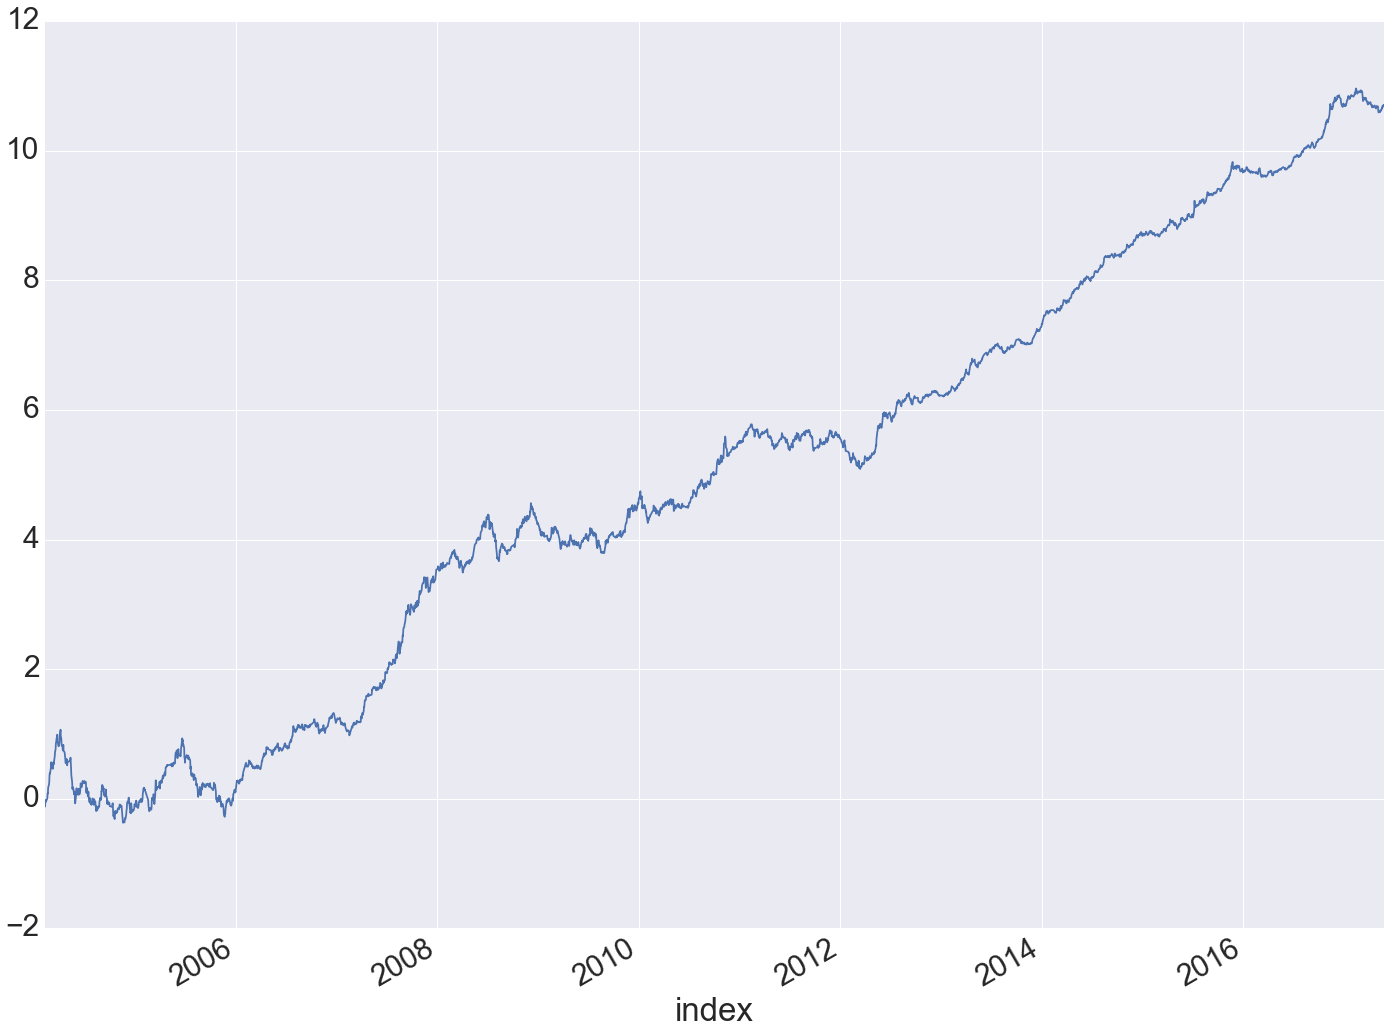

In [49]:
ew_portfolio_pnl(pnl).cumsum().plot()

# Calculating portfolio diversification number

Calculate the achieved versus target volatility to create the scaling factor.  Since I'm targetting all markets to hit 100% volatility this number should be less than 1

$$ \sigma_{target} = \sqrt{w'\Sigma w} * ScalingFactor $$


$$  ScalingFactor=\frac{\sigma_{target}}{ \sqrt{w'\Sigma w}}  $$



In [121]:
m=['A','M','C','L','P','TA','CF','V','FG']

In [122]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))

In [123]:
np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16

0.4196579429583035

In [124]:
ew_portfolio_pnl(pnl[m])['2012':].std()*16

0.43141379081507236

In [126]:
Sigma=pnl[m]['2012':].dropna(axis=1,how='all').cov().as_matrix()
w=np.array([1/float(len(m))]*len(m))
vol_ach=np.sqrt(np.dot(np.dot(w.T,Sigma),w))*16
vol_target=.15
portfolio_diversification= vol_target/vol_ach

In [127]:
portfolio_diversification

0.35743395905389486

# Time varying portfolio scaler for back test


* Use long term covariance matrix $\Sigma_{all}$
* Calculate $\frac{1}{N}$ portfolio weights at all times
* No shrinkage used, but also because weights are robust

$$  ScalingFactor_t=\frac{\sigma_{target}}{ \sqrt{w_t'\Sigma w_t}}  $$

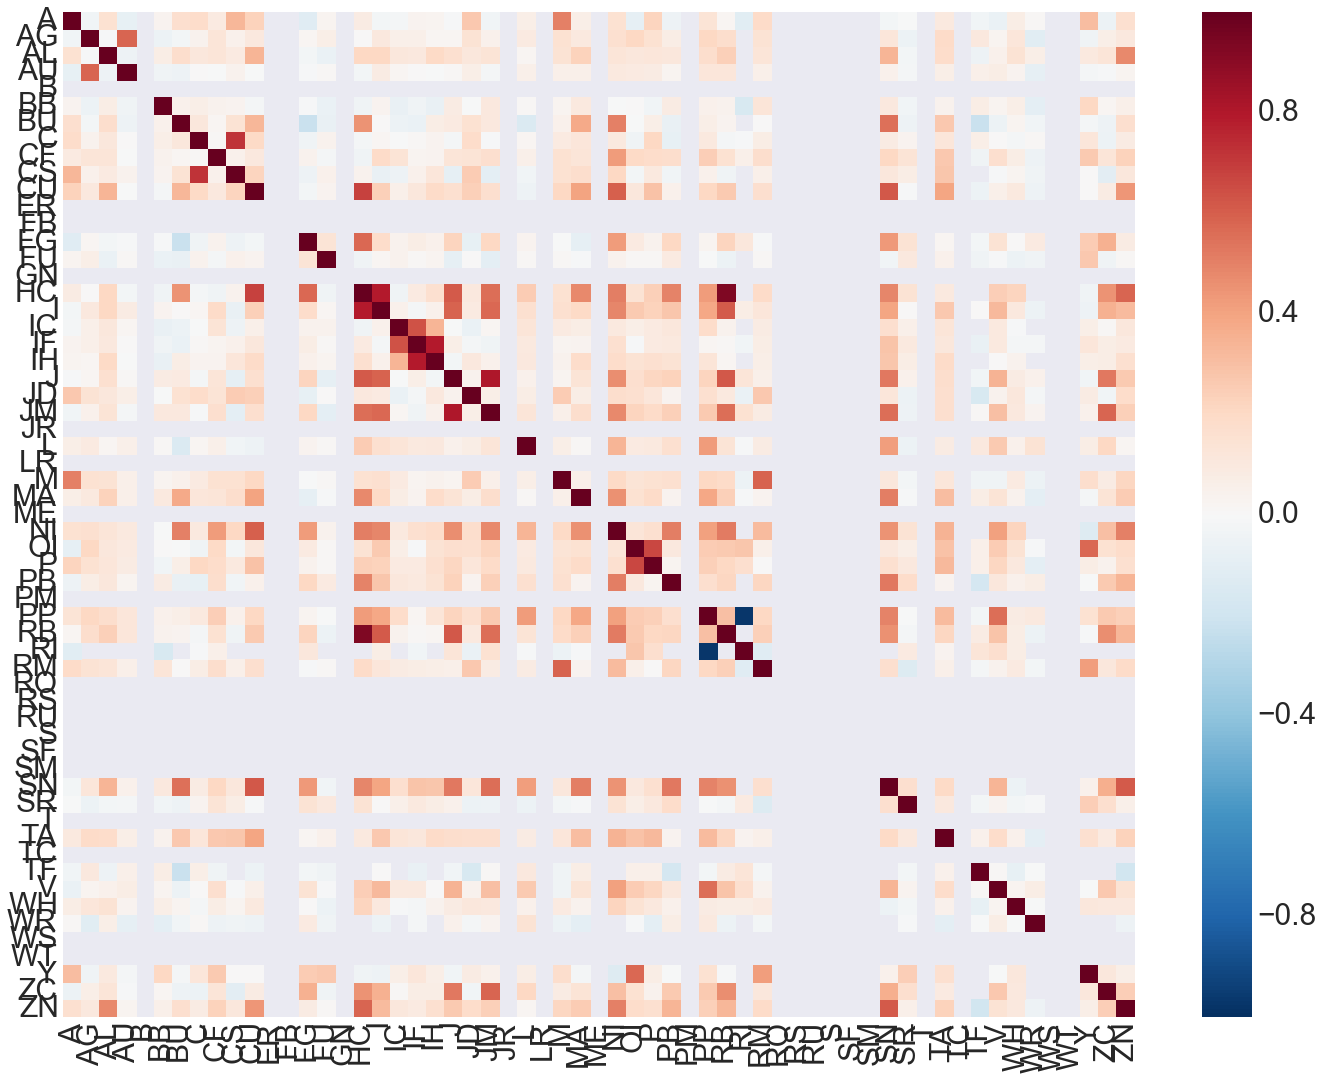

In [225]:
sns.heatmap(pnl.corr())

In [226]:
def calc_scaling_factor(pnl,vol_target=0.15):
    Sigma_all=pnl.cov().dropna(how='all',axis=1).dropna(how='all')
    ind=pnl.dropna(how='all').index
    SF=[]
    for row in pnl.dropna(how='all').iterrows():
        no_mkts=row[1].dropna().count()
        w=np.array([1/float(no_mkts)]*no_mkts)
        mkt_list=row[1].dropna().index
        Sig = Sigma_all[mkt_list].T[mkt_list]
        vol_ach=np.sqrt(np.dot(np.dot(w.T,Sig.as_matrix()),w))*16
        SF.append(vol_target/vol_ach)
    return pd.Series(SF,index=ind)

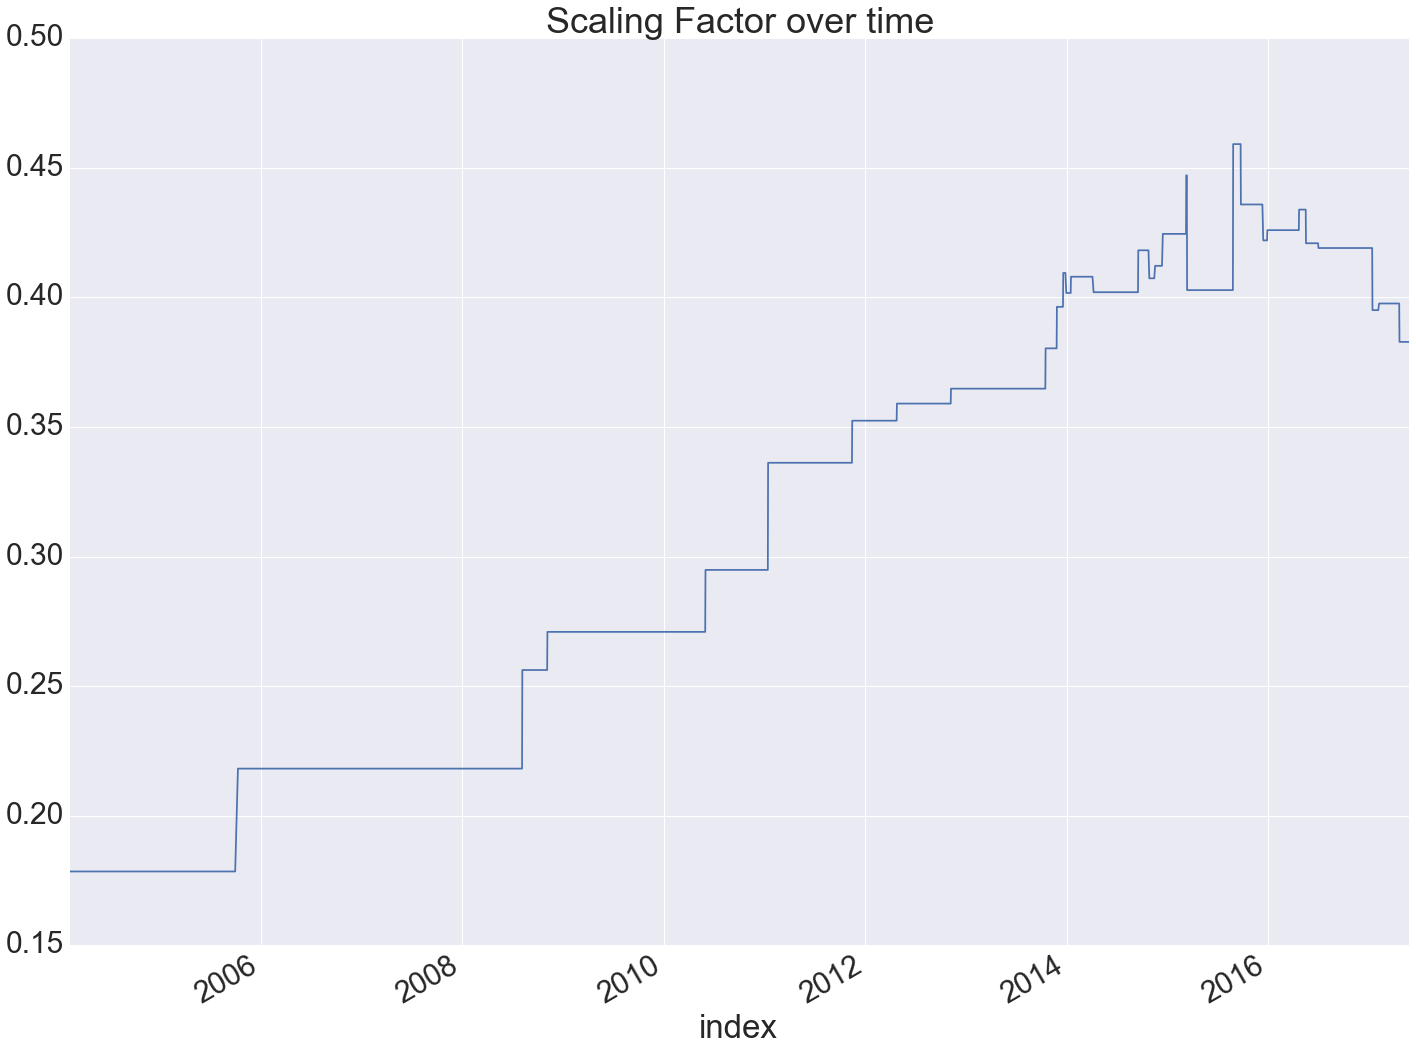

In [212]:
scaling_factor=calc_scaling_factor(pnl)
scaling_factor.plot(title='Scaling Factor over time')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,center=False).std()
  if __name__ == '__main__':


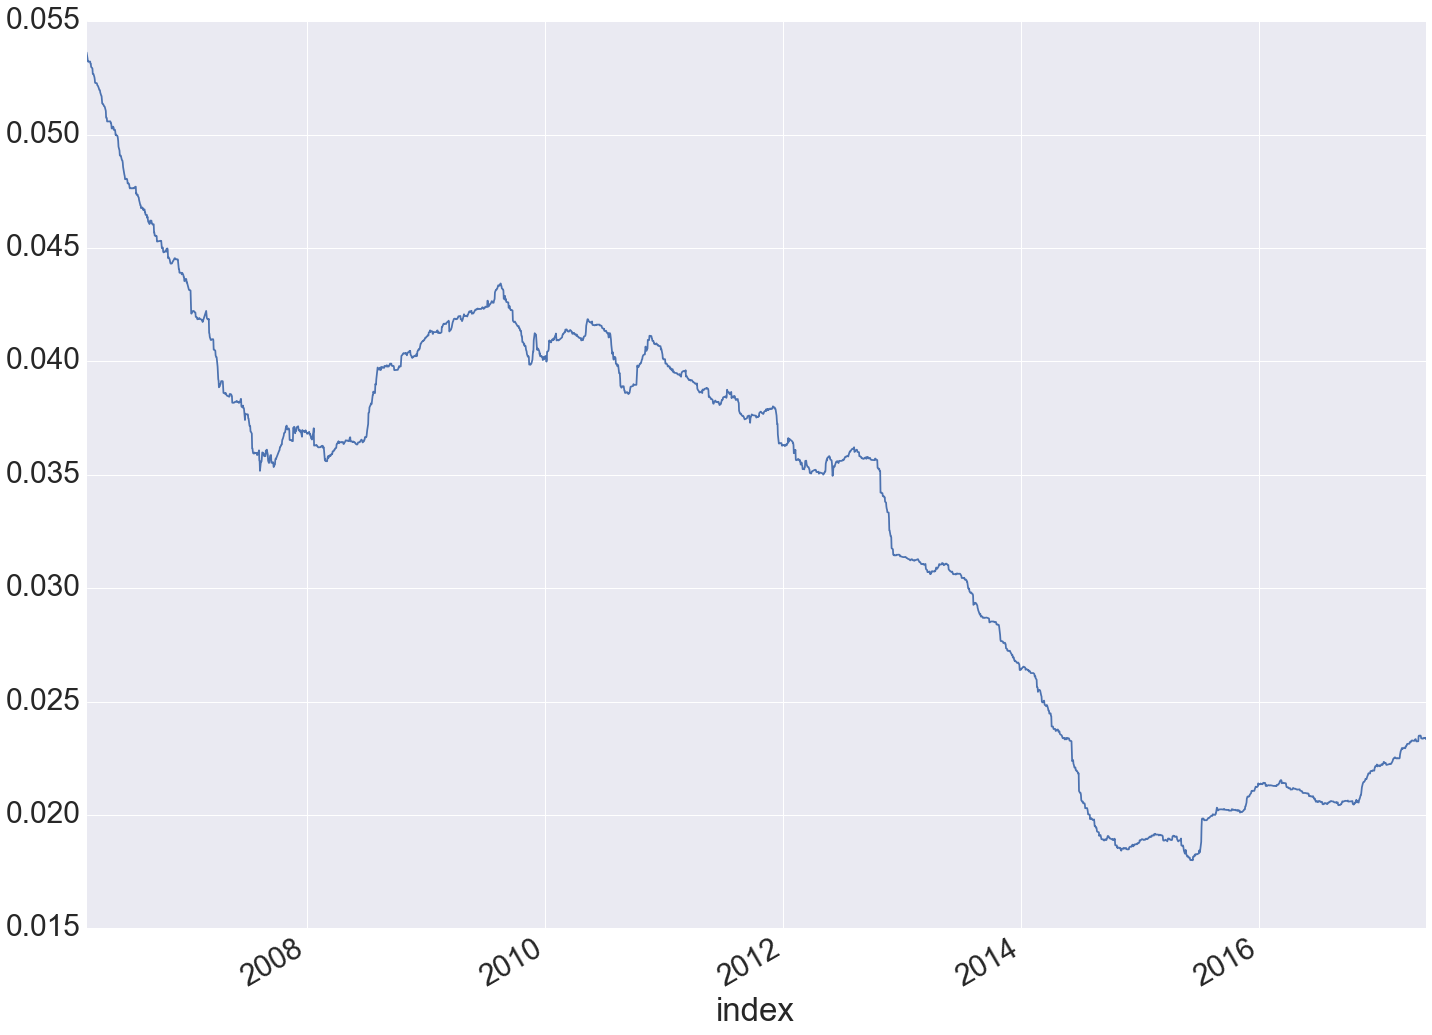

In [213]:
pd.rolling_std(pnl.mean(axis=1),500).dropna().plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=120,adjust=True,com=120).std(bias=False)
  if __name__ == '__main__':


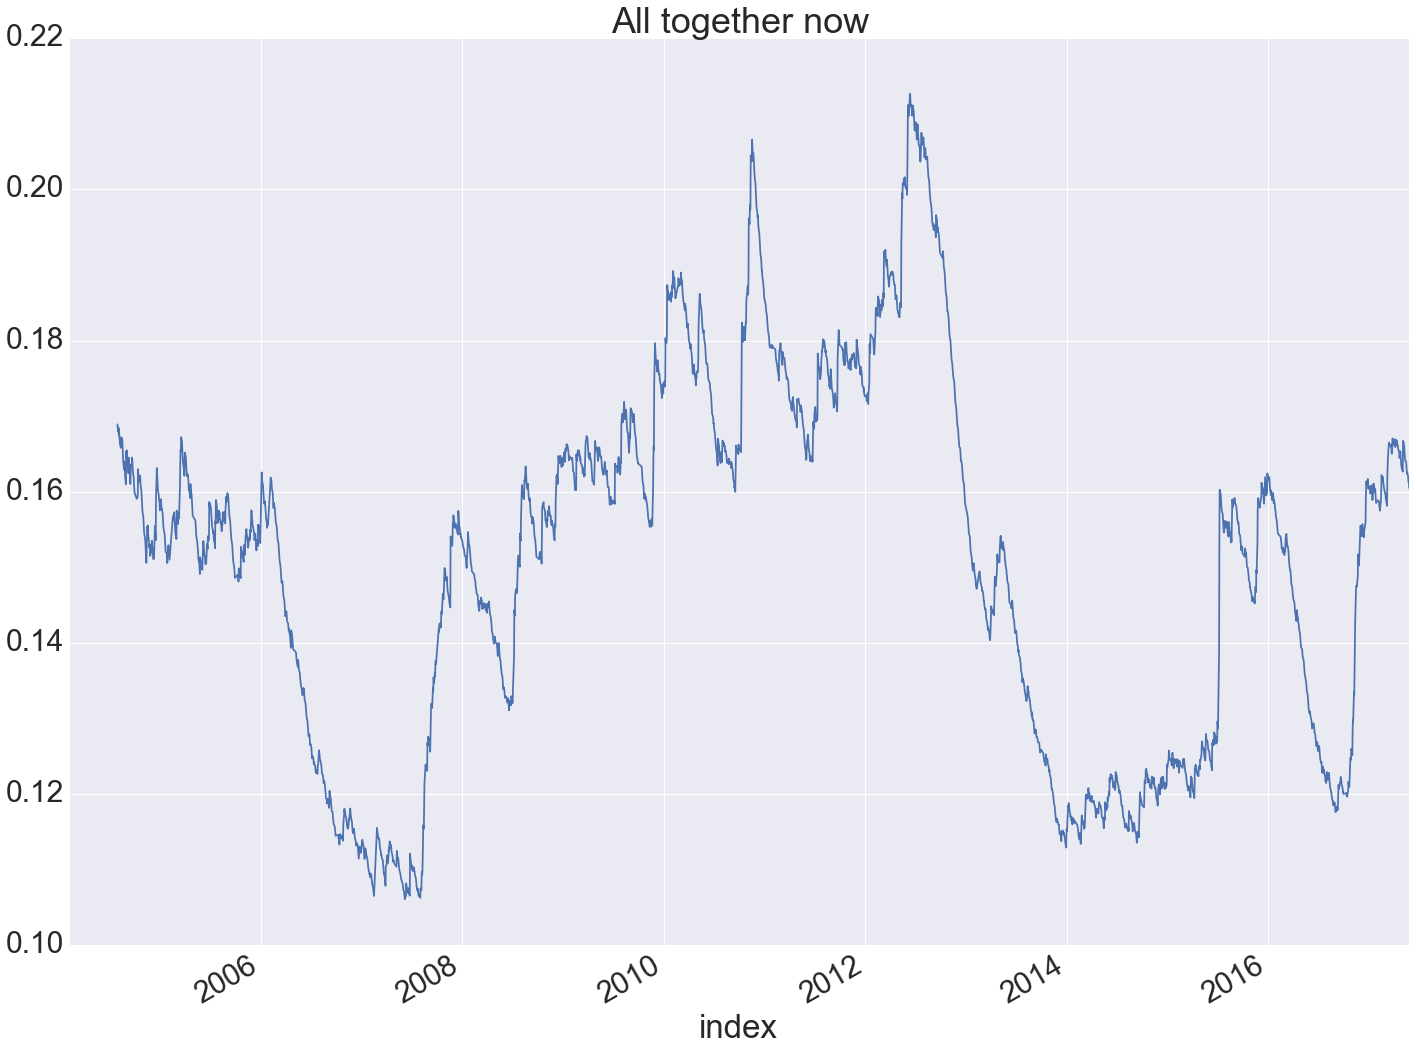

In [224]:
(pd.ewmstd((pnl.mean(axis=1).dropna()*scaling_factor),120,min_periods=120)*16).plot(title='All together now')